### How to run Metrcs on DDF or areas that are outside WFD and DDF

In [1]:
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# To calculate metrics with MAF
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.batches as batches

In [3]:
# import convenience functions
from opsimUtils import *

### ProposalId
To run metrics on DDF or areas outside DDF and WFD, we need to set the `proposalId` in the sql contraint. In short, if running metric on DDFs only, `proposalId > 1`; if running metrics in areas outside DDF and WDF, `proposalId = 0`. We get all also run WFD only metrics using `proposalId = 1`, but a more sophisticated methods is shown in [wfdFootPrint.ipynb](./04_wfdFootPrint.ipynb). More discussion regarding running metrics on WFD observations only can be found in this [thread](https://community.lsst.org/t/wfd-metrics-with-the-fbs-output/3970).

The area associated with each `proposalId` for one particular cadence simulation is shown below:  
```sql
proposalId  proposalName  proposalType
----------  ------------  ------------
0           Other         Other
1           WFD           WFD
2           DD:COSMOS     DD
3           DD:ECDFS      DD
4           DD:290        DD
5           DD:XMM-LSS    DD
6           DD:ELAISS1    DD
```

#### **Important:** 
The assignment of a proposal ID to a DDF field is **NOT** consistent across all opsims. Meaning that, 'proposalId = 2' may point to the 'COSMOS' field in opsim A, but point to the 'XMM-LSS' field in opsim B. So we wrote a convenience function (`ddfInfo`) to get that information from the opsim databases, where a opsim database object and the name of the DDF field ('COSMOS', 'ECDFS', '290', 'XMM-LSS' or 'ELAISS1') should be provided. In addition, in FBS 1.5 run, the DDF '290' field, which is a placeholder for the 5th DDF field in all earlier FBS runs is replaced by the 'EDFS' field (Euclid Deep Field South). You can use the function `get_ddfNames()` to obtain the avaiable designated names for the DDFs with the opsim database object as the only input.

Next, we demonstrat how to run metrics on DDF only and on areas outside DDF and WFD.

In [4]:
# specify path to the opsim database and create database object
dbfile = '/home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db'
outDir = '../tmp/'
opsdb = db.OpsimDatabase(dbfile)

Use `ddfInfo` to get associated `proposalId` for each DDF field

In [5]:
# show names for the DDFs
get_ddfNames(opsdb)

['COSMOS', 'ELAISS1', 'ECDFS', 'EDFS', 'XMM-LSS']

In [6]:
# get the metadata for a particular DDF given the name 
ddfInfo(opsdb, 'XMM-LSS')

{'proposalId': 6, 'Coord': (35.707, -4.72)}

In [7]:
# Let's count the visits .. 
metric = metrics.CountMetric('observationStartMJD', metricName='nvisits')
slicer = slicers.HealpixSlicer(nside=128)
constraint = 'filter = "g"'

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


### 1. Compute Metrics on DDF only

In [8]:
# specify proposal ID use compute metric on DDF only
ddf_constraint = constraint + ' and proposalId > 1'

# create metric Bundle
ddf_bundle = mb.MetricBundle(metric, slicer, ddf_constraint, metadata='DDF only')

Querying database SummaryAllProps with constraint filter = "g" and proposalId > 1 for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 12117 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g" and proposalId > 1" constraint now.
monopole: 1639.7  dipole: lon: -72.582, lat: 53.3575, amp: 931.377
Plotting complete.


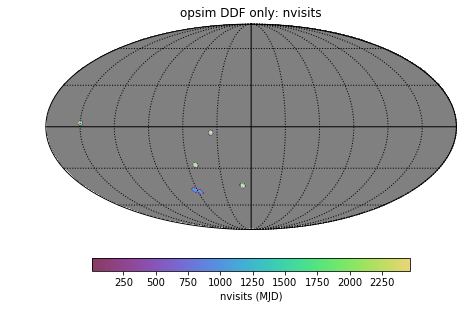

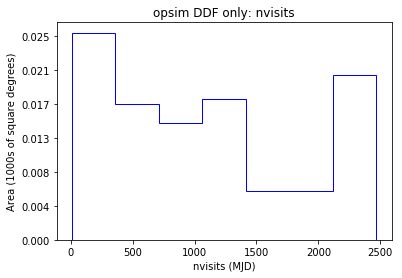

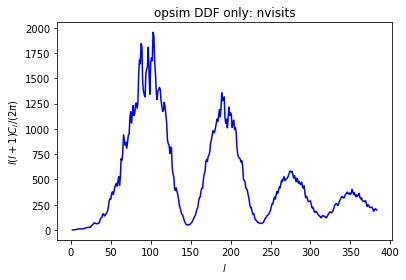

In [9]:
ddf_g = mb.MetricBundleGroup({'0': ddf_bundle}, opsdb, outDir=outDir)
ddf_g.runAll()
ddf_g.plotAll(closefigs=False, savefig=False)

### 2. Compute Metrics on areas outside DDF and WFD

In [11]:
# specify proposal ID use compute metric on DDF only
other_constraint = constraint + ' and proposalId = 0'

# create metric Bundle
other_bundle = mb.MetricBundle(metric, slicer, other_constraint, metadata='Other')

Querying database SummaryAllProps with constraint filter = "g" and proposalId = 0 for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 38742 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g" and proposalId = 0" constraint now.
monopole: 36.05  dipole: lon: 91.8851, lat: -29.8671, amp: 6.82151
Plotting complete.


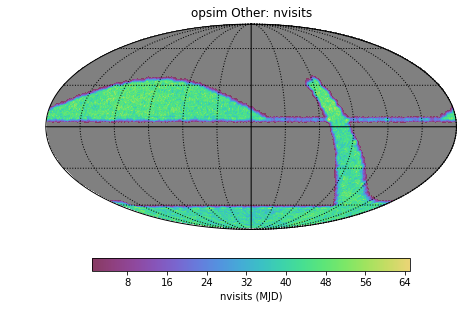

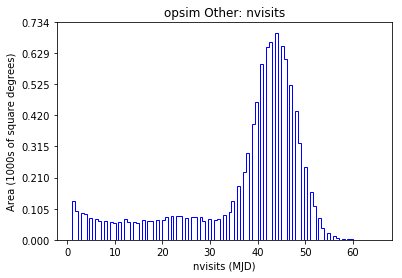

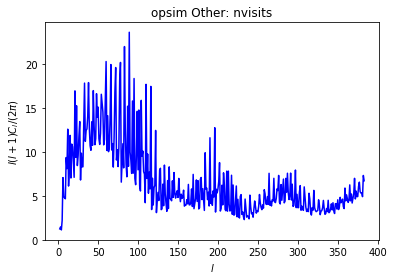

In [12]:
other_g = mb.MetricBundleGroup({'0': other_bundle}, opsdb, outDir=outDir)
other_g.runAll()
other_g.plotAll(closefigs=False, savefig=False)